# Train Mask -> SLO on Colab TPU (v6e-1)

This notebook is configured for Google Drive data at:
`/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/SLO_VESSELS`

Recommended runtime:
1. Runtime -> Change runtime type
2. Hardware accelerator: `TPU`
3. TPU type: `v6e-1` (if available)
        


In [2]:
from google.colab import drive

drive.mount('/content/drive')
        


Mounted at /content/drive


In [3]:
!pip -q install --upgrade numpy Pillow tqdm
        


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 181.2 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.63.1 requires numpy<2.4,>=1.22, but you have numpy 2.4.2 which is incompatible.


In [4]:
from pathlib import Path

# Paths
DATA_DIR = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/SLO_VESSELS')
OUTPUT_DIR = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e3_gn_warmup')

# Training config
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 512
EPOCHS = 600
BATCH_SIZE = 2
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-6
LR_PLATEAU_FACTOR = 0.7
LR_PLATEAU_PATIENCE = 25
LR_PLATEAU_THRESHOLD = 5e-4
LR_PLATEAU_COOLDOWN = 4
MIN_LEARNING_RATE = 3e-7
WARMUP_EPOCHS = 12
WARMUP_START_FACTOR = 0.2
VAL_FRACTION = 0.2
HFLIP_PROB = 0.5
VFLIP_PROB = 0.0
ROTATE_DEG = 3.0
BASE_CHANNELS = 32
NUM_WORKERS = 0
SEED = 42
GRAD_CLIP = 0.7
NORM_GROUPS = 8
USE_AMP = False  # TPU path ignores AMP
REQUIRE_TPU = True

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'previews').mkdir(parents=True, exist_ok=True)

print('DATA_DIR exists:', DATA_DIR.exists())
print('OUTPUT_DIR:', OUTPUT_DIR)
        


DATA_DIR exists: True
OUTPUT_DIR: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e3_gn_warmup


In [5]:
import contextlib
import json
import random
import re
from dataclasses import dataclass
from typing import Dict, List, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

VALID_IMAGE_SUFFIXES = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}
PAIR_REGEX = re.compile(r'^(slo|vessels)_(\d+)$', re.IGNORECASE)

# Runtime detection: TPU (torch_xla) preferred for v6e-1
use_tpu = False
xm = None
pl = None
xr = None
torch_xla = None

try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.runtime as xr

    runtime_type = xr.device_type().upper()
    if runtime_type == 'TPU':
        use_tpu = True
except Exception as e:
    print('torch_xla not available or TPU init failed:', e)

if REQUIRE_TPU and not use_tpu:
    raise RuntimeError(
        'TPU runtime not active. In Colab choose TPU runtime (v6e-1 if available), reconnect, and rerun.'
    )

if use_tpu:
    device = xm.xla_device()

    def sync_step() -> None:
        if hasattr(torch_xla, 'sync'):
            torch_xla.sync()
        else:
            xm.mark_step()
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def sync_step() -> None:
        return None

print('Torch:', torch.__version__)
print('Using TPU:', use_tpu)
print('Device:', device)


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if not use_tpu and torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


@dataclass(frozen=True)
class PairRecord:
    index: int
    mask_path: Path
    slo_path: Path


def discover_pairs(data_dir: Path) -> List[PairRecord]:
    grouped: Dict[int, Dict[str, Path]] = {}
    for path in sorted(data_dir.glob('*')):
        if not path.is_file() or path.suffix.lower() not in VALID_IMAGE_SUFFIXES:
            continue
        match = PAIR_REGEX.match(path.stem)
        if not match:
            continue
        kind, idx_str = match.groups()
        idx = int(idx_str)
        grouped.setdefault(idx, {})[kind.lower()] = path

    records: List[PairRecord] = []
    missing: List[int] = []
    for idx in sorted(grouped):
        slot = grouped[idx]
        if 'slo' not in slot or 'vessels' not in slot:
            missing.append(idx)
            continue
        records.append(PairRecord(index=idx, mask_path=slot['vessels'], slo_path=slot['slo']))

    if missing:
        raise ValueError(f'Incomplete pairs for indices: {missing}')
    if not records:
        raise ValueError(f'No slo_<n> + vessels_<n> pairs found in {data_dir}')
    return records


def split_pairs(records: Sequence[PairRecord], val_fraction: float, seed: int) -> Tuple[List[PairRecord], List[PairRecord]]:
    if not (0.0 < val_fraction < 1.0):
        raise ValueError('val_fraction must be in (0, 1)')
    shuffled = list(records)
    rng = random.Random(seed)
    rng.shuffle(shuffled)
    val_count = max(1, int(round(len(shuffled) * val_fraction)))
    train = shuffled[val_count:]
    val = shuffled[:val_count]
    if not train:
        raise ValueError('Train split is empty; lower val_fraction or add data')
    return train, val


class SLOPairDataset(Dataset):
    def __init__(
        self,
        records: Sequence[PairRecord],
        image_width: int,
        image_height: int,
        augment: bool,
        hflip_prob: float,
        vflip_prob: float,
        rotate_deg: float,
    ) -> None:
        self.records = list(records)
        self.image_width = image_width
        self.image_height = image_height
        self.augment = augment
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.rotate_deg = rotate_deg

    def __len__(self) -> int:
        return len(self.records)

    def _sync_augment(self, mask_img: Image.Image, slo_img: Image.Image):
        if random.random() < self.hflip_prob:
            mask_img = ImageOps.mirror(mask_img)
            slo_img = ImageOps.mirror(slo_img)
        if random.random() < self.vflip_prob:
            mask_img = ImageOps.flip(mask_img)
            slo_img = ImageOps.flip(slo_img)
        if self.rotate_deg > 0:
            angle = random.uniform(-self.rotate_deg, self.rotate_deg)
            mask_img = mask_img.rotate(angle, resample=Image.Resampling.NEAREST, fillcolor=0)
            slo_img = slo_img.rotate(angle, resample=Image.Resampling.BILINEAR, fillcolor=0)
        return mask_img, slo_img

    def __getitem__(self, idx: int):
        rec = self.records[idx]
        with Image.open(rec.mask_path) as mask_img, Image.open(rec.slo_path) as slo_img:
            mask_img = mask_img.convert('L')
            slo_img = slo_img.convert('L')

            if mask_img.size != slo_img.size:
                raise ValueError(f'Size mismatch index {rec.index}: {mask_img.size} vs {slo_img.size}')

            if self.augment:
                mask_img, slo_img = self._sync_augment(mask_img, slo_img)

            mask_img = mask_img.resize((self.image_width, self.image_height), resample=Image.Resampling.NEAREST)
            slo_img = slo_img.resize((self.image_width, self.image_height), resample=Image.Resampling.BILINEAR)

            mask_arr = np.asarray(mask_img, dtype=np.float32) / 255.0
            slo_arr = np.asarray(slo_img, dtype=np.float32) / 255.0

        return {
            'mask': torch.from_numpy(mask_arr).unsqueeze(0),
            'slo': torch.from_numpy(slo_arr).unsqueeze(0),
            'index': rec.index,
        }


def make_norm(num_channels: int, max_groups: int = NORM_GROUPS) -> nn.GroupNorm:
    groups = min(max_groups, num_channels)
    while num_channels % groups != 0:
        groups -= 1
    return nn.GroupNorm(groups, num_channels)


class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            make_norm(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            make_norm(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool_conv(x)


class Up(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int) -> None:
        super().__init__()
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


class UNetGenerator(nn.Module):
    def __init__(self, in_ch: int = 1, out_ch: int = 1, base_ch: int = 32) -> None:
        super().__init__()
        self.in_conv = DoubleConv(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch * 2)
        self.down2 = Down(base_ch * 2, base_ch * 4)
        self.down3 = Down(base_ch * 4, base_ch * 8)
        self.bottleneck = Down(base_ch * 8, base_ch * 8)

        self.up1 = Up(base_ch * 8, base_ch * 8, base_ch * 4)
        self.up2 = Up(base_ch * 4, base_ch * 4, base_ch * 2)
        self.up3 = Up(base_ch * 2, base_ch * 2, base_ch)
        self.up4 = Up(base_ch, base_ch, base_ch)
        self.out_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        xb = self.bottleneck(x4)
        x = self.up1(xb, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return torch.sigmoid(self.out_conv(x))


def save_preview(mask: torch.Tensor, pred: torch.Tensor, target: torch.Tensor, out_path: Path) -> None:
    mask_u8 = (mask.squeeze().detach().cpu().numpy().clip(0, 1) * 255.0).astype(np.uint8)
    pred_u8 = (pred.squeeze().detach().cpu().numpy().clip(0, 1) * 255.0).astype(np.uint8)
    tgt_u8 = (target.squeeze().detach().cpu().numpy().clip(0, 1) * 255.0).astype(np.uint8)
    tiled = np.concatenate([mask_u8, pred_u8, tgt_u8], axis=1)
    Image.fromarray(tiled, mode='L').save(out_path)
        


/tmp/ipython-input-3251454681.py:44: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


Torch: 2.9.0+cpu
Using TPU: True
Device: xla:0


In [6]:
set_seed(SEED)
records = discover_pairs(DATA_DIR)
train_records, val_records = split_pairs(records, VAL_FRACTION, SEED)

print(f'Total pairs: {len(records)} | Train: {len(train_records)} | Val: {len(val_records)}')
print('Train indices:', [r.index for r in train_records])
print('Val indices:', [r.index for r in val_records])

train_ds = SLOPairDataset(
    records=train_records,
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    augment=True,
    hflip_prob=HFLIP_PROB,
    vflip_prob=VFLIP_PROB,
    rotate_deg=ROTATE_DEG,
)
val_ds = SLOPairDataset(
    records=val_records,
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    augment=False,
    hflip_prob=0.0,
    vflip_prob=0.0,
    rotate_deg=0.0,
)

train_host_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(not use_tpu and torch.cuda.is_available()),
)
val_host_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(not use_tpu and torch.cuda.is_available()),
)

train_loader = pl.MpDeviceLoader(train_host_loader, device) if use_tpu else train_host_loader
val_loader = pl.MpDeviceLoader(val_host_loader, device) if use_tpu else val_host_loader

model = UNetGenerator(base_ch=BASE_CHANNELS).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=LR_PLATEAU_FACTOR,
    patience=LR_PLATEAU_PATIENCE,
    threshold=LR_PLATEAU_THRESHOLD,
    cooldown=LR_PLATEAU_COOLDOWN,
    min_lr=MIN_LEARNING_RATE,
)
criterion = nn.L1Loss()

amp_enabled = bool((not use_tpu) and (device.type == 'cuda') and USE_AMP)
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
amp_context = torch.cuda.amp.autocast if amp_enabled else contextlib.nullcontext

history = []
best_val = float('inf')
        


Total pairs: 22 | Train: 18 | Val: 4
Train indices: [10, 13, 17, 20, 7, 14, 19, 15, 11, 2, 12, 5, 18, 8, 9, 1, 4, 21]
Val indices: [22, 6, 3, 16]


/tmp/ipython-input-2956668770.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


In [7]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    if WARMUP_EPOCHS > 0 and epoch <= WARMUP_EPOCHS:
        warmup_frac = epoch / WARMUP_EPOCHS
        warmup_lr = LEARNING_RATE * (WARMUP_START_FACTOR + (1.0 - WARMUP_START_FACTOR) * warmup_frac)
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr

    for batch in tqdm(train_loader, desc=f'Epoch {epoch:03d} train', leave=False):
        if use_tpu:
            masks = batch['mask']
            targets = batch['slo']
        else:
            masks = batch['mask'].to(device, non_blocking=True)
            targets = batch['slo'].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with amp_context():
            preds = model(masks)
            loss = criterion(preds, targets)

        if use_tpu:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            xm.optimizer_step(optimizer, barrier=True)
            sync_step()
        else:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()

        train_losses.append(float(loss.detach().cpu().item()))

    model.eval()
    val_losses = []
    preview_saved = False

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch:03d} val', leave=False):
            if use_tpu:
                masks = batch['mask']
                targets = batch['slo']
            else:
                masks = batch['mask'].to(device, non_blocking=True)
                targets = batch['slo'].to(device, non_blocking=True)

            preds = model(masks)
            val_loss = criterion(preds, targets)
            val_losses.append(float(val_loss.detach().cpu().item()))

            if not preview_saved:
                preview_path = OUTPUT_DIR / 'previews' / f'epoch_{epoch:03d}.png'
                save_preview(masks[0], preds[0], targets[0], preview_path)
                preview_saved = True

        sync_step()

    train_l1 = float(np.mean(train_losses)) if train_losses else float('nan')
    val_l1 = float(np.mean(val_losses)) if val_losses else train_l1
    if epoch > WARMUP_EPOCHS:
        scheduler.step(val_l1)
    lr = optimizer.param_groups[0]['lr']

    row = {'epoch': epoch, 'train_l1': train_l1, 'val_l1': val_l1, 'lr': lr}
    history.append(row)

    checkpoint = {
        'epoch': epoch,
        'model_state': {k: v.detach().cpu() for k, v in model.state_dict().items()},
        'optimizer_state': optimizer.state_dict(),
        'args': {
            'image_width': IMAGE_WIDTH,
            'image_height': IMAGE_HEIGHT,
            'base_channels': BASE_CHANNELS,
            'norm_groups': NORM_GROUPS,
            'hflip_prob': HFLIP_PROB,
            'vflip_prob': VFLIP_PROB,
            'rotate_deg': ROTATE_DEG,
            'batch_size': BATCH_SIZE,
            'epochs': EPOCHS,
            'learning_rate': LEARNING_RATE,
            'weight_decay': WEIGHT_DECAY,
            'lr_plateau_factor': LR_PLATEAU_FACTOR,
            'lr_plateau_patience': LR_PLATEAU_PATIENCE,
            'lr_plateau_threshold': LR_PLATEAU_THRESHOLD,
            'lr_plateau_cooldown': LR_PLATEAU_COOLDOWN,
            'min_learning_rate': MIN_LEARNING_RATE,
            'warmup_epochs': WARMUP_EPOCHS,
            'warmup_start_factor': WARMUP_START_FACTOR,
            'val_fraction': VAL_FRACTION,
            'seed': SEED,
            'data_dir': str(DATA_DIR),
            'output_dir': str(OUTPUT_DIR),
            'use_tpu': use_tpu,
        },
        'train_records': [r.index for r in train_records],
        'val_records': [r.index for r in val_records],
        'history': history,
        'best_val': best_val,
    }

    torch.save(checkpoint, OUTPUT_DIR / 'latest.pt')

    if val_l1 < best_val:
        best_val = val_l1
        checkpoint['best_val'] = best_val
        torch.save(checkpoint, OUTPUT_DIR / 'best.pt')

    print(f"Epoch {epoch:03d}/{EPOCHS} | train_l1={train_l1:.6f} | val_l1={val_l1:.6f} | lr={lr:.2e}")

(OUTPUT_DIR / 'history.json').write_text(json.dumps(history, indent=2), encoding='utf-8')
(OUTPUT_DIR / 'train_config.json').write_text(
    json.dumps(
        {
            'data_dir': str(DATA_DIR),
            'image_width': IMAGE_WIDTH,
            'image_height': IMAGE_HEIGHT,
            'train_count': len(train_records),
            'val_count': len(val_records),
            'hflip_prob': HFLIP_PROB,
            'vflip_prob': VFLIP_PROB,
            'rotate_deg': ROTATE_DEG,
            'base_channels': BASE_CHANNELS,
            'norm_groups': NORM_GROUPS,
            'epochs': EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'weight_decay': WEIGHT_DECAY,
            'grad_clip': GRAD_CLIP,
            'lr_plateau_factor': LR_PLATEAU_FACTOR,
            'lr_plateau_patience': LR_PLATEAU_PATIENCE,
            'lr_plateau_threshold': LR_PLATEAU_THRESHOLD,
            'lr_plateau_cooldown': LR_PLATEAU_COOLDOWN,
            'min_learning_rate': MIN_LEARNING_RATE,
            'warmup_epochs': WARMUP_EPOCHS,
            'warmup_start_factor': WARMUP_START_FACTOR,
            'best_val_l1': best_val,
            'use_tpu': use_tpu,
        },
        indent=2,
    ),
    encoding='utf-8',
)

print('Training complete. Best val_l1:', best_val)
print('Saved under:', OUTPUT_DIR)
        


Epoch 001 train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Epoch 001/600 | train_l1=0.102969 | val_l1=0.102003 | lr=8.00e-06


Epoch 002/600 | train_l1=0.099896 | val_l1=0.101490 | lr=1.00e-05


Epoch 003/600 | train_l1=0.098384 | val_l1=0.101792 | lr=1.20e-05


Epoch 004/600 | train_l1=0.098672 | val_l1=0.103212 | lr=1.40e-05


Epoch 005/600 | train_l1=0.098529 | val_l1=0.100257 | lr=1.60e-05


Epoch 006/600 | train_l1=0.096519 | val_l1=0.102213 | lr=1.80e-05


Epoch 007/600 | train_l1=0.095105 | val_l1=0.100285 | lr=2.00e-05


Epoch 008/600 | train_l1=0.094375 | val_l1=0.100835 | lr=2.20e-05


Epoch 009/600 | train_l1=0.093189 | val_l1=0.098546 | lr=2.40e-05


Epoch 010/600 | train_l1=0.094055 | val_l1=0.096731 | lr=2.60e-05


Epoch 011/600 | train_l1=0.094888 | val_l1=0.098161 | lr=2.80e-05


Epoch 012/600 | train_l1=0.091903 | val_l1=0.098616 | lr=3.00e-05


Epoch 013/600 | train_l1=0.092506 | val_l1=0.095782 | lr=3.00e-05


Epoch 014/600 | train_l1=0.092289 | val_l1=0.096526 | lr=3.00e-05


Epoch 015/600 | train_l1=0.091530 | val_l1=0.095176 | lr=3.00e-05


Epoch 016/600 | train_l1=0.092780 | val_l1=0.097592 | lr=3.00e-05


Epoch 017/600 | train_l1=0.093034 | val_l1=0.097379 | lr=3.00e-05


Epoch 018/600 | train_l1=0.091717 | val_l1=0.096160 | lr=3.00e-05


Epoch 019/600 | train_l1=0.092181 | val_l1=0.094504 | lr=3.00e-05


Epoch 020/600 | train_l1=0.090788 | val_l1=0.092849 | lr=3.00e-05


Epoch 021/600 | train_l1=0.094916 | val_l1=0.094841 | lr=3.00e-05


Epoch 022/600 | train_l1=0.088517 | val_l1=0.095932 | lr=3.00e-05


Epoch 023/600 | train_l1=0.089802 | val_l1=0.091556 | lr=3.00e-05


Epoch 024/600 | train_l1=0.088362 | val_l1=0.094113 | lr=3.00e-05


Epoch 025/600 | train_l1=0.087147 | val_l1=0.090105 | lr=3.00e-05


Epoch 026/600 | train_l1=0.090049 | val_l1=0.090646 | lr=3.00e-05


Epoch 027/600 | train_l1=0.086007 | val_l1=0.093795 | lr=3.00e-05


Epoch 028/600 | train_l1=0.092944 | val_l1=0.090727 | lr=3.00e-05


Epoch 029/600 | train_l1=0.087277 | val_l1=0.091340 | lr=3.00e-05


Epoch 030/600 | train_l1=0.086577 | val_l1=0.091828 | lr=3.00e-05


Epoch 031/600 | train_l1=0.085326 | val_l1=0.087340 | lr=3.00e-05


Epoch 032/600 | train_l1=0.084145 | val_l1=0.085101 | lr=3.00e-05


Epoch 033/600 | train_l1=0.085532 | val_l1=0.086265 | lr=3.00e-05


Epoch 034/600 | train_l1=0.087748 | val_l1=0.091476 | lr=3.00e-05


Epoch 035/600 | train_l1=0.086340 | val_l1=0.085718 | lr=3.00e-05


Epoch 036/600 | train_l1=0.083043 | val_l1=0.087313 | lr=3.00e-05


Epoch 037/600 | train_l1=0.093456 | val_l1=0.097676 | lr=3.00e-05


Epoch 038/600 | train_l1=0.086386 | val_l1=0.089072 | lr=3.00e-05


Epoch 039/600 | train_l1=0.083659 | val_l1=0.082502 | lr=3.00e-05


Epoch 040/600 | train_l1=0.085294 | val_l1=0.090425 | lr=3.00e-05


Epoch 041/600 | train_l1=0.082950 | val_l1=0.082409 | lr=3.00e-05


Epoch 042/600 | train_l1=0.082658 | val_l1=0.082277 | lr=3.00e-05


Epoch 043/600 | train_l1=0.088714 | val_l1=0.094502 | lr=3.00e-05


Epoch 044/600 | train_l1=0.089890 | val_l1=0.088415 | lr=3.00e-05


Epoch 045/600 | train_l1=0.083374 | val_l1=0.085947 | lr=3.00e-05


Epoch 046/600 | train_l1=0.080113 | val_l1=0.085069 | lr=3.00e-05


Epoch 047/600 | train_l1=0.079593 | val_l1=0.079618 | lr=3.00e-05


Epoch 048/600 | train_l1=0.082840 | val_l1=0.081684 | lr=3.00e-05


Epoch 049/600 | train_l1=0.084209 | val_l1=0.086086 | lr=3.00e-05


Epoch 050/600 | train_l1=0.077938 | val_l1=0.079830 | lr=3.00e-05


Epoch 051/600 | train_l1=0.079228 | val_l1=0.079629 | lr=3.00e-05


Epoch 052/600 | train_l1=0.080622 | val_l1=0.078517 | lr=3.00e-05


Epoch 053/600 | train_l1=0.077353 | val_l1=0.088236 | lr=3.00e-05


Epoch 054/600 | train_l1=0.081046 | val_l1=0.084868 | lr=3.00e-05


Epoch 055/600 | train_l1=0.081197 | val_l1=0.082178 | lr=3.00e-05


Epoch 056/600 | train_l1=0.075044 | val_l1=0.078833 | lr=3.00e-05


Epoch 057/600 | train_l1=0.080806 | val_l1=0.078603 | lr=3.00e-05


Epoch 058/600 | train_l1=0.073958 | val_l1=0.080366 | lr=3.00e-05


Epoch 059/600 | train_l1=0.074759 | val_l1=0.076218 | lr=3.00e-05


Epoch 060/600 | train_l1=0.071761 | val_l1=0.082000 | lr=3.00e-05


Epoch 061/600 | train_l1=0.074752 | val_l1=0.084685 | lr=3.00e-05


Epoch 062/600 | train_l1=0.072608 | val_l1=0.075179 | lr=3.00e-05


Epoch 063/600 | train_l1=0.069324 | val_l1=0.080584 | lr=3.00e-05


Epoch 064/600 | train_l1=0.070393 | val_l1=0.072858 | lr=3.00e-05


Epoch 065/600 | train_l1=0.075344 | val_l1=0.069949 | lr=3.00e-05


Epoch 066/600 | train_l1=0.069004 | val_l1=0.076496 | lr=3.00e-05


Epoch 067/600 | train_l1=0.068710 | val_l1=0.072821 | lr=3.00e-05


Epoch 068/600 | train_l1=0.067505 | val_l1=0.070686 | lr=3.00e-05


Epoch 069/600 | train_l1=0.070056 | val_l1=0.093468 | lr=3.00e-05


Epoch 070/600 | train_l1=0.067174 | val_l1=0.072303 | lr=3.00e-05


Epoch 071/600 | train_l1=0.067979 | val_l1=0.074125 | lr=3.00e-05


Epoch 072/600 | train_l1=0.065452 | val_l1=0.071994 | lr=3.00e-05


Epoch 073/600 | train_l1=0.063776 | val_l1=0.069136 | lr=3.00e-05


Epoch 074/600 | train_l1=0.070829 | val_l1=0.086180 | lr=3.00e-05


Epoch 075/600 | train_l1=0.065828 | val_l1=0.074386 | lr=3.00e-05


Epoch 076/600 | train_l1=0.067428 | val_l1=0.080016 | lr=3.00e-05


Epoch 077/600 | train_l1=0.065569 | val_l1=0.075761 | lr=3.00e-05


Epoch 078/600 | train_l1=0.070380 | val_l1=0.078309 | lr=3.00e-05


Epoch 079/600 | train_l1=0.065679 | val_l1=0.069590 | lr=3.00e-05


Epoch 080/600 | train_l1=0.062751 | val_l1=0.077484 | lr=3.00e-05


Epoch 081/600 | train_l1=0.061033 | val_l1=0.075393 | lr=3.00e-05


Epoch 082/600 | train_l1=0.064594 | val_l1=0.071071 | lr=3.00e-05


Epoch 083/600 | train_l1=0.061887 | val_l1=0.068902 | lr=3.00e-05


Epoch 084/600 | train_l1=0.062626 | val_l1=0.078128 | lr=3.00e-05


Epoch 085/600 | train_l1=0.066419 | val_l1=0.080303 | lr=3.00e-05


Epoch 086/600 | train_l1=0.063263 | val_l1=0.069969 | lr=3.00e-05


Epoch 087/600 | train_l1=0.061113 | val_l1=0.072702 | lr=3.00e-05


Epoch 088/600 | train_l1=0.063426 | val_l1=0.071960 | lr=3.00e-05


Epoch 089/600 | train_l1=0.061741 | val_l1=0.074273 | lr=3.00e-05


Epoch 090/600 | train_l1=0.060742 | val_l1=0.071264 | lr=3.00e-05


Epoch 091/600 | train_l1=0.060114 | val_l1=0.068505 | lr=3.00e-05


Epoch 092/600 | train_l1=0.061083 | val_l1=0.067921 | lr=3.00e-05


Epoch 093/600 | train_l1=0.060313 | val_l1=0.065993 | lr=3.00e-05


Epoch 094/600 | train_l1=0.060560 | val_l1=0.066548 | lr=3.00e-05


Epoch 095/600 | train_l1=0.062784 | val_l1=0.066703 | lr=3.00e-05


Epoch 096/600 | train_l1=0.058454 | val_l1=0.066733 | lr=3.00e-05


Epoch 097/600 | train_l1=0.060439 | val_l1=0.070441 | lr=3.00e-05


Epoch 098/600 | train_l1=0.061027 | val_l1=0.073155 | lr=3.00e-05


Epoch 099/600 | train_l1=0.058295 | val_l1=0.074753 | lr=3.00e-05


Epoch 100/600 | train_l1=0.059493 | val_l1=0.069623 | lr=3.00e-05


Epoch 101/600 | train_l1=0.060070 | val_l1=0.072183 | lr=3.00e-05


Epoch 102/600 | train_l1=0.057951 | val_l1=0.066462 | lr=3.00e-05


Epoch 103/600 | train_l1=0.058933 | val_l1=0.068037 | lr=3.00e-05


Epoch 104/600 | train_l1=0.058190 | val_l1=0.075709 | lr=3.00e-05


Epoch 105/600 | train_l1=0.057854 | val_l1=0.072832 | lr=3.00e-05


Epoch 106/600 | train_l1=0.059132 | val_l1=0.070317 | lr=3.00e-05


Epoch 107/600 | train_l1=0.057490 | val_l1=0.067707 | lr=3.00e-05


Epoch 108/600 | train_l1=0.056661 | val_l1=0.068181 | lr=3.00e-05


Epoch 109/600 | train_l1=0.057156 | val_l1=0.066323 | lr=3.00e-05


Epoch 110/600 | train_l1=0.059258 | val_l1=0.072023 | lr=3.00e-05


Epoch 111/600 | train_l1=0.057505 | val_l1=0.071996 | lr=3.00e-05


Epoch 112/600 | train_l1=0.056999 | val_l1=0.070678 | lr=3.00e-05


Epoch 113/600 | train_l1=0.057284 | val_l1=0.078698 | lr=3.00e-05


Epoch 114/600 | train_l1=0.056230 | val_l1=0.070508 | lr=3.00e-05


Epoch 115/600 | train_l1=0.054728 | val_l1=0.066216 | lr=3.00e-05


Epoch 116/600 | train_l1=0.055245 | val_l1=0.074090 | lr=3.00e-05


Epoch 117/600 | train_l1=0.054041 | val_l1=0.072122 | lr=3.00e-05


Epoch 118/600 | train_l1=0.055646 | val_l1=0.070478 | lr=3.00e-05


Epoch 119/600 | train_l1=0.054619 | val_l1=0.065548 | lr=3.00e-05


Epoch 120/600 | train_l1=0.055195 | val_l1=0.065197 | lr=3.00e-05


Epoch 121/600 | train_l1=0.055700 | val_l1=0.070935 | lr=3.00e-05


Epoch 122/600 | train_l1=0.056583 | val_l1=0.068400 | lr=3.00e-05


Epoch 123/600 | train_l1=0.057161 | val_l1=0.065518 | lr=3.00e-05


Epoch 124/600 | train_l1=0.053315 | val_l1=0.067084 | lr=3.00e-05


Epoch 125/600 | train_l1=0.052566 | val_l1=0.068352 | lr=3.00e-05


Epoch 126/600 | train_l1=0.052925 | val_l1=0.067673 | lr=3.00e-05


Epoch 127/600 | train_l1=0.054325 | val_l1=0.073249 | lr=3.00e-05


Epoch 128/600 | train_l1=0.054186 | val_l1=0.066951 | lr=3.00e-05


Epoch 129/600 | train_l1=0.053536 | val_l1=0.066930 | lr=3.00e-05


Epoch 130/600 | train_l1=0.051982 | val_l1=0.071665 | lr=3.00e-05


Epoch 131/600 | train_l1=0.051965 | val_l1=0.066933 | lr=3.00e-05


Epoch 132/600 | train_l1=0.054690 | val_l1=0.065698 | lr=3.00e-05


Epoch 133/600 | train_l1=0.054272 | val_l1=0.065931 | lr=3.00e-05


Epoch 134/600 | train_l1=0.055660 | val_l1=0.069406 | lr=3.00e-05


Epoch 135/600 | train_l1=0.053696 | val_l1=0.066598 | lr=3.00e-05


Epoch 136/600 | train_l1=0.055785 | val_l1=0.071446 | lr=3.00e-05


Epoch 137/600 | train_l1=0.056748 | val_l1=0.071849 | lr=3.00e-05


Epoch 138/600 | train_l1=0.054893 | val_l1=0.069988 | lr=3.00e-05


Epoch 139/600 | train_l1=0.050761 | val_l1=0.070497 | lr=3.00e-05


Epoch 140/600 | train_l1=0.049402 | val_l1=0.071811 | lr=3.00e-05


Epoch 141/600 | train_l1=0.050792 | val_l1=0.072404 | lr=3.00e-05


Epoch 142/600 | train_l1=0.051721 | val_l1=0.066665 | lr=3.00e-05


Epoch 143/600 | train_l1=0.052345 | val_l1=0.066992 | lr=3.00e-05


Epoch 144/600 | train_l1=0.051059 | val_l1=0.068690 | lr=3.00e-05


Epoch 145/600 | train_l1=0.050638 | val_l1=0.067752 | lr=3.00e-05


Epoch 146/600 | train_l1=0.048539 | val_l1=0.069208 | lr=2.10e-05


Epoch 147/600 | train_l1=0.049556 | val_l1=0.065758 | lr=2.10e-05


Epoch 148/600 | train_l1=0.049016 | val_l1=0.066207 | lr=2.10e-05


Epoch 149/600 | train_l1=0.048911 | val_l1=0.071169 | lr=2.10e-05


Epoch 150/600 | train_l1=0.049058 | val_l1=0.065247 | lr=2.10e-05


Epoch 151/600 | train_l1=0.047937 | val_l1=0.069399 | lr=2.10e-05


Epoch 152/600 | train_l1=0.046763 | val_l1=0.065342 | lr=2.10e-05


Epoch 153/600 | train_l1=0.047200 | val_l1=0.067075 | lr=2.10e-05


Epoch 154/600 | train_l1=0.047578 | val_l1=0.072060 | lr=2.10e-05


Epoch 155/600 | train_l1=0.048665 | val_l1=0.069591 | lr=2.10e-05


Epoch 156/600 | train_l1=0.046431 | val_l1=0.065593 | lr=2.10e-05


Epoch 157/600 | train_l1=0.047371 | val_l1=0.066587 | lr=2.10e-05


Epoch 158/600 | train_l1=0.046851 | val_l1=0.068819 | lr=2.10e-05


Epoch 159/600 | train_l1=0.045832 | val_l1=0.064125 | lr=2.10e-05


Epoch 160/600 | train_l1=0.046553 | val_l1=0.065631 | lr=2.10e-05


Epoch 161/600 | train_l1=0.046133 | val_l1=0.066831 | lr=2.10e-05


Epoch 162/600 | train_l1=0.046381 | val_l1=0.071603 | lr=2.10e-05


Epoch 163/600 | train_l1=0.046955 | val_l1=0.067233 | lr=2.10e-05


Epoch 164/600 | train_l1=0.047646 | val_l1=0.068812 | lr=2.10e-05


Epoch 165/600 | train_l1=0.047328 | val_l1=0.064978 | lr=2.10e-05


Epoch 166/600 | train_l1=0.046492 | val_l1=0.067927 | lr=2.10e-05


Epoch 167/600 | train_l1=0.046234 | val_l1=0.065923 | lr=2.10e-05


Epoch 168/600 | train_l1=0.045514 | val_l1=0.066657 | lr=2.10e-05


Epoch 169/600 | train_l1=0.045981 | val_l1=0.067042 | lr=2.10e-05


Epoch 170/600 | train_l1=0.045886 | val_l1=0.065475 | lr=2.10e-05


Epoch 171/600 | train_l1=0.046345 | val_l1=0.068158 | lr=2.10e-05


Epoch 172/600 | train_l1=0.045833 | val_l1=0.065871 | lr=2.10e-05


Epoch 173/600 | train_l1=0.046620 | val_l1=0.066042 | lr=2.10e-05


Epoch 174/600 | train_l1=0.045657 | val_l1=0.064812 | lr=2.10e-05


Epoch 175/600 | train_l1=0.044775 | val_l1=0.068045 | lr=2.10e-05


Epoch 176/600 | train_l1=0.043874 | val_l1=0.065497 | lr=2.10e-05


Epoch 177/600 | train_l1=0.045860 | val_l1=0.069319 | lr=2.10e-05


Epoch 178/600 | train_l1=0.044492 | val_l1=0.065254 | lr=2.10e-05


Epoch 179/600 | train_l1=0.045276 | val_l1=0.070162 | lr=2.10e-05


Epoch 180/600 | train_l1=0.046010 | val_l1=0.066975 | lr=2.10e-05


Epoch 181/600 | train_l1=0.044897 | val_l1=0.065774 | lr=2.10e-05


Epoch 182/600 | train_l1=0.046028 | val_l1=0.064728 | lr=2.10e-05


Epoch 183/600 | train_l1=0.044485 | val_l1=0.065536 | lr=2.10e-05


Epoch 184/600 | train_l1=0.044258 | val_l1=0.070381 | lr=2.10e-05


Epoch 185/600 | train_l1=0.043984 | val_l1=0.068003 | lr=1.47e-05


Epoch 186/600 | train_l1=0.043293 | val_l1=0.066541 | lr=1.47e-05


Epoch 187/600 | train_l1=0.042380 | val_l1=0.070623 | lr=1.47e-05


Epoch 188/600 | train_l1=0.042171 | val_l1=0.067514 | lr=1.47e-05


Epoch 189/600 | train_l1=0.042877 | val_l1=0.067639 | lr=1.47e-05


Epoch 190/600 | train_l1=0.043685 | val_l1=0.066130 | lr=1.47e-05


Epoch 191/600 | train_l1=0.043476 | val_l1=0.066094 | lr=1.47e-05


Epoch 192/600 | train_l1=0.042850 | val_l1=0.067678 | lr=1.47e-05


Epoch 193/600 | train_l1=0.042860 | val_l1=0.069261 | lr=1.47e-05


Epoch 194/600 | train_l1=0.041893 | val_l1=0.066129 | lr=1.47e-05


Epoch 195/600 | train_l1=0.041390 | val_l1=0.064609 | lr=1.47e-05


Epoch 196/600 | train_l1=0.042969 | val_l1=0.068972 | lr=1.47e-05


Epoch 197/600 | train_l1=0.041597 | val_l1=0.068527 | lr=1.47e-05


Epoch 198/600 | train_l1=0.041044 | val_l1=0.066685 | lr=1.47e-05


Epoch 199/600 | train_l1=0.041449 | val_l1=0.069553 | lr=1.47e-05


Epoch 200/600 | train_l1=0.041859 | val_l1=0.065106 | lr=1.47e-05


Epoch 201/600 | train_l1=0.041817 | val_l1=0.068244 | lr=1.47e-05


Epoch 202/600 | train_l1=0.040571 | val_l1=0.067873 | lr=1.47e-05


Epoch 203/600 | train_l1=0.041987 | val_l1=0.069849 | lr=1.47e-05


Epoch 204/600 | train_l1=0.042129 | val_l1=0.068830 | lr=1.47e-05


Epoch 205/600 | train_l1=0.041356 | val_l1=0.066277 | lr=1.47e-05


Epoch 206/600 | train_l1=0.041087 | val_l1=0.067084 | lr=1.47e-05


Epoch 207/600 | train_l1=0.040741 | val_l1=0.065753 | lr=1.47e-05


Epoch 208/600 | train_l1=0.041402 | val_l1=0.065620 | lr=1.47e-05


Epoch 209/600 | train_l1=0.040986 | val_l1=0.066550 | lr=1.47e-05


Epoch 210/600 | train_l1=0.041299 | val_l1=0.066664 | lr=1.47e-05


Epoch 211/600 | train_l1=0.041924 | val_l1=0.065272 | lr=1.47e-05


Epoch 212/600 | train_l1=0.041476 | val_l1=0.065757 | lr=1.47e-05


Epoch 213/600 | train_l1=0.041551 | val_l1=0.067043 | lr=1.47e-05


Epoch 214/600 | train_l1=0.041318 | val_l1=0.064989 | lr=1.47e-05


Epoch 215/600 | train_l1=0.040971 | val_l1=0.065799 | lr=1.03e-05


Epoch 216/600 | train_l1=0.040311 | val_l1=0.066500 | lr=1.03e-05


Epoch 217/600 | train_l1=0.040484 | val_l1=0.069512 | lr=1.03e-05


Epoch 218/600 | train_l1=0.040423 | val_l1=0.065385 | lr=1.03e-05


Epoch 219/600 | train_l1=0.040330 | val_l1=0.068856 | lr=1.03e-05


Epoch 220/600 | train_l1=0.039241 | val_l1=0.068220 | lr=1.03e-05


Epoch 221/600 | train_l1=0.041086 | val_l1=0.070767 | lr=1.03e-05


Epoch 222/600 | train_l1=0.039614 | val_l1=0.064805 | lr=1.03e-05


Epoch 223/600 | train_l1=0.040065 | val_l1=0.070192 | lr=1.03e-05


Epoch 224/600 | train_l1=0.040275 | val_l1=0.065921 | lr=1.03e-05


Epoch 225/600 | train_l1=0.039810 | val_l1=0.068908 | lr=1.03e-05


Epoch 226/600 | train_l1=0.039481 | val_l1=0.065132 | lr=1.03e-05


Epoch 227/600 | train_l1=0.039273 | val_l1=0.065755 | lr=1.03e-05


Epoch 228/600 | train_l1=0.038787 | val_l1=0.066451 | lr=1.03e-05


Epoch 229/600 | train_l1=0.039656 | val_l1=0.067165 | lr=1.03e-05


Epoch 230/600 | train_l1=0.039003 | val_l1=0.066239 | lr=1.03e-05


Epoch 231/600 | train_l1=0.039142 | val_l1=0.067696 | lr=1.03e-05


Epoch 232/600 | train_l1=0.038929 | val_l1=0.065920 | lr=1.03e-05


Epoch 233/600 | train_l1=0.038699 | val_l1=0.067631 | lr=1.03e-05


Epoch 234/600 | train_l1=0.039693 | val_l1=0.067825 | lr=1.03e-05


Epoch 235/600 | train_l1=0.039959 | val_l1=0.068810 | lr=1.03e-05


Epoch 236/600 | train_l1=0.039629 | val_l1=0.068423 | lr=1.03e-05


Epoch 237/600 | train_l1=0.039454 | val_l1=0.067048 | lr=1.03e-05


Epoch 238/600 | train_l1=0.039482 | val_l1=0.066923 | lr=1.03e-05


Epoch 239/600 | train_l1=0.038159 | val_l1=0.066742 | lr=1.03e-05


Epoch 240/600 | train_l1=0.038533 | val_l1=0.067355 | lr=1.03e-05


Epoch 241/600 | train_l1=0.038265 | val_l1=0.065148 | lr=1.03e-05


Epoch 242/600 | train_l1=0.038857 | val_l1=0.067451 | lr=1.03e-05


Epoch 243/600 | train_l1=0.038850 | val_l1=0.066090 | lr=1.03e-05


Epoch 244/600 | train_l1=0.038276 | val_l1=0.065439 | lr=1.03e-05


Epoch 245/600 | train_l1=0.040016 | val_l1=0.069413 | lr=7.20e-06


Epoch 246/600 | train_l1=0.038890 | val_l1=0.066470 | lr=7.20e-06


Epoch 247/600 | train_l1=0.037735 | val_l1=0.066537 | lr=7.20e-06


Epoch 248/600 | train_l1=0.038187 | val_l1=0.067325 | lr=7.20e-06


Epoch 249/600 | train_l1=0.037591 | val_l1=0.066741 | lr=7.20e-06


Epoch 250/600 | train_l1=0.038123 | val_l1=0.067616 | lr=7.20e-06


Epoch 251/600 | train_l1=0.037986 | val_l1=0.067111 | lr=7.20e-06


Epoch 252/600 | train_l1=0.037921 | val_l1=0.067409 | lr=7.20e-06


Epoch 253/600 | train_l1=0.038381 | val_l1=0.068018 | lr=7.20e-06


Epoch 254/600 | train_l1=0.037871 | val_l1=0.066697 | lr=7.20e-06


Epoch 255/600 | train_l1=0.038117 | val_l1=0.067628 | lr=7.20e-06


Epoch 256/600 | train_l1=0.038758 | val_l1=0.068073 | lr=7.20e-06


Epoch 257/600 | train_l1=0.038687 | val_l1=0.069111 | lr=7.20e-06


Epoch 258/600 | train_l1=0.038461 | val_l1=0.068159 | lr=7.20e-06


Epoch 259/600 | train_l1=0.038207 | val_l1=0.067194 | lr=7.20e-06


Epoch 260/600 | train_l1=0.037553 | val_l1=0.068956 | lr=7.20e-06


Epoch 261/600 | train_l1=0.038868 | val_l1=0.068198 | lr=7.20e-06


Epoch 262/600 | train_l1=0.038438 | val_l1=0.068434 | lr=7.20e-06


Epoch 263/600 | train_l1=0.038623 | val_l1=0.067257 | lr=7.20e-06


Epoch 264/600 | train_l1=0.037889 | val_l1=0.066987 | lr=7.20e-06


Epoch 265/600 | train_l1=0.037903 | val_l1=0.067227 | lr=7.20e-06


Epoch 266/600 | train_l1=0.037051 | val_l1=0.067103 | lr=7.20e-06


Epoch 267/600 | train_l1=0.037219 | val_l1=0.067553 | lr=7.20e-06


Epoch 268/600 | train_l1=0.037776 | val_l1=0.066585 | lr=7.20e-06


Epoch 269/600 | train_l1=0.037989 | val_l1=0.066292 | lr=7.20e-06


Epoch 270/600 | train_l1=0.038039 | val_l1=0.068375 | lr=7.20e-06


Epoch 271/600 | train_l1=0.037549 | val_l1=0.067203 | lr=7.20e-06


Epoch 272/600 | train_l1=0.037084 | val_l1=0.066199 | lr=7.20e-06


Epoch 273/600 | train_l1=0.038095 | val_l1=0.069859 | lr=7.20e-06


Epoch 274/600 | train_l1=0.037372 | val_l1=0.066712 | lr=7.20e-06


Epoch 275/600 | train_l1=0.037613 | val_l1=0.069056 | lr=5.04e-06


Epoch 276/600 | train_l1=0.037236 | val_l1=0.069039 | lr=5.04e-06


Epoch 277/600 | train_l1=0.037271 | val_l1=0.066792 | lr=5.04e-06


Epoch 278/600 | train_l1=0.037358 | val_l1=0.068524 | lr=5.04e-06


Epoch 279/600 | train_l1=0.037022 | val_l1=0.068730 | lr=5.04e-06


Epoch 280/600 | train_l1=0.037318 | val_l1=0.066847 | lr=5.04e-06


Epoch 281/600 | train_l1=0.038070 | val_l1=0.068707 | lr=5.04e-06


Epoch 282/600 | train_l1=0.036885 | val_l1=0.068219 | lr=5.04e-06


Epoch 283/600 | train_l1=0.037685 | val_l1=0.067576 | lr=5.04e-06


Epoch 284/600 | train_l1=0.037345 | val_l1=0.067595 | lr=5.04e-06


Epoch 285/600 | train_l1=0.036610 | val_l1=0.068339 | lr=5.04e-06


Epoch 286/600 | train_l1=0.037015 | val_l1=0.067959 | lr=5.04e-06


Epoch 287/600 | train_l1=0.036992 | val_l1=0.066401 | lr=5.04e-06


Epoch 288/600 | train_l1=0.038111 | val_l1=0.069780 | lr=5.04e-06


Epoch 289/600 | train_l1=0.037190 | val_l1=0.067801 | lr=5.04e-06


Epoch 290/600 | train_l1=0.037280 | val_l1=0.068822 | lr=5.04e-06


Epoch 291/600 | train_l1=0.036338 | val_l1=0.067500 | lr=5.04e-06


Epoch 292/600 | train_l1=0.036689 | val_l1=0.067959 | lr=5.04e-06


Epoch 293/600 | train_l1=0.037109 | val_l1=0.068111 | lr=5.04e-06


Epoch 294/600 | train_l1=0.037972 | val_l1=0.068869 | lr=5.04e-06


Epoch 295/600 | train_l1=0.036508 | val_l1=0.067454 | lr=5.04e-06


Epoch 296/600 | train_l1=0.036503 | val_l1=0.067604 | lr=5.04e-06


Epoch 297/600 | train_l1=0.037602 | val_l1=0.069801 | lr=5.04e-06


Epoch 298/600 | train_l1=0.037236 | val_l1=0.068433 | lr=5.04e-06


Epoch 299/600 | train_l1=0.036572 | val_l1=0.068034 | lr=5.04e-06


Epoch 300/600 | train_l1=0.036766 | val_l1=0.067314 | lr=5.04e-06


Epoch 301/600 | train_l1=0.037986 | val_l1=0.068582 | lr=5.04e-06


Epoch 302/600 | train_l1=0.036558 | val_l1=0.067161 | lr=5.04e-06


Epoch 303/600 | train_l1=0.036882 | val_l1=0.067914 | lr=5.04e-06


Epoch 304/600 | train_l1=0.036455 | val_l1=0.067746 | lr=5.04e-06


Epoch 305/600 | train_l1=0.036517 | val_l1=0.067722 | lr=3.53e-06


Epoch 306/600 | train_l1=0.036250 | val_l1=0.067871 | lr=3.53e-06


Epoch 307/600 | train_l1=0.036059 | val_l1=0.067378 | lr=3.53e-06


Epoch 308/600 | train_l1=0.037115 | val_l1=0.068323 | lr=3.53e-06


Epoch 309/600 | train_l1=0.036725 | val_l1=0.067953 | lr=3.53e-06


Epoch 310/600 | train_l1=0.036976 | val_l1=0.067684 | lr=3.53e-06


Epoch 311/600 | train_l1=0.036384 | val_l1=0.068590 | lr=3.53e-06


Epoch 312/600 | train_l1=0.037333 | val_l1=0.068344 | lr=3.53e-06


Epoch 313/600 | train_l1=0.036520 | val_l1=0.067017 | lr=3.53e-06


Epoch 314/600 | train_l1=0.036124 | val_l1=0.067702 | lr=3.53e-06


Epoch 315/600 | train_l1=0.037102 | val_l1=0.067879 | lr=3.53e-06


Epoch 316/600 | train_l1=0.036671 | val_l1=0.067567 | lr=3.53e-06


Epoch 317/600 | train_l1=0.036957 | val_l1=0.067934 | lr=3.53e-06


Epoch 318/600 | train_l1=0.035800 | val_l1=0.067230 | lr=3.53e-06


Epoch 319/600 | train_l1=0.036096 | val_l1=0.067259 | lr=3.53e-06


Epoch 320/600 | train_l1=0.036474 | val_l1=0.068139 | lr=3.53e-06


Epoch 321/600 | train_l1=0.036449 | val_l1=0.067662 | lr=3.53e-06


Epoch 322/600 | train_l1=0.037026 | val_l1=0.066812 | lr=3.53e-06


Epoch 323/600 | train_l1=0.036104 | val_l1=0.068220 | lr=3.53e-06


Epoch 324/600 | train_l1=0.036971 | val_l1=0.067500 | lr=3.53e-06


Epoch 325/600 | train_l1=0.036314 | val_l1=0.068491 | lr=3.53e-06


Epoch 326/600 | train_l1=0.036772 | val_l1=0.068378 | lr=3.53e-06


Epoch 327/600 | train_l1=0.036270 | val_l1=0.068452 | lr=3.53e-06


Epoch 328/600 | train_l1=0.036158 | val_l1=0.068029 | lr=3.53e-06


Epoch 329/600 | train_l1=0.036115 | val_l1=0.067149 | lr=3.53e-06


Epoch 330/600 | train_l1=0.036442 | val_l1=0.067359 | lr=3.53e-06


Epoch 331/600 | train_l1=0.036160 | val_l1=0.068354 | lr=3.53e-06


Epoch 332/600 | train_l1=0.035825 | val_l1=0.066977 | lr=3.53e-06


Epoch 333/600 | train_l1=0.036184 | val_l1=0.067424 | lr=3.53e-06


Epoch 334/600 | train_l1=0.036660 | val_l1=0.068434 | lr=3.53e-06


Epoch 335/600 | train_l1=0.036541 | val_l1=0.067411 | lr=2.47e-06


Epoch 336/600 | train_l1=0.036231 | val_l1=0.068993 | lr=2.47e-06


Epoch 337/600 | train_l1=0.036340 | val_l1=0.067396 | lr=2.47e-06


Epoch 338/600 | train_l1=0.035858 | val_l1=0.068314 | lr=2.47e-06


Epoch 339/600 | train_l1=0.035693 | val_l1=0.068149 | lr=2.47e-06


Epoch 340/600 | train_l1=0.036822 | val_l1=0.067650 | lr=2.47e-06


Epoch 341/600 | train_l1=0.036322 | val_l1=0.068549 | lr=2.47e-06


Epoch 342/600 | train_l1=0.036037 | val_l1=0.067941 | lr=2.47e-06


Epoch 343/600 | train_l1=0.035981 | val_l1=0.066669 | lr=2.47e-06


Epoch 344/600 | train_l1=0.036120 | val_l1=0.067613 | lr=2.47e-06


Epoch 345/600 | train_l1=0.036251 | val_l1=0.067776 | lr=2.47e-06


Epoch 346/600 | train_l1=0.035808 | val_l1=0.067840 | lr=2.47e-06


Epoch 347/600 | train_l1=0.035934 | val_l1=0.067905 | lr=2.47e-06


Epoch 348/600 | train_l1=0.035407 | val_l1=0.067871 | lr=2.47e-06


Epoch 349/600 | train_l1=0.036053 | val_l1=0.067827 | lr=2.47e-06


Epoch 350/600 | train_l1=0.035845 | val_l1=0.067803 | lr=2.47e-06


Epoch 351/600 | train_l1=0.035946 | val_l1=0.068140 | lr=2.47e-06


Epoch 352/600 | train_l1=0.035549 | val_l1=0.067942 | lr=2.47e-06


Epoch 353/600 | train_l1=0.036358 | val_l1=0.067467 | lr=2.47e-06


Epoch 354/600 | train_l1=0.036424 | val_l1=0.068312 | lr=2.47e-06


Epoch 355/600 | train_l1=0.036169 | val_l1=0.067859 | lr=2.47e-06


Epoch 356/600 | train_l1=0.035992 | val_l1=0.067216 | lr=2.47e-06


Epoch 357/600 | train_l1=0.036708 | val_l1=0.068812 | lr=2.47e-06


Epoch 358/600 | train_l1=0.036235 | val_l1=0.068908 | lr=2.47e-06


Epoch 359/600 | train_l1=0.036693 | val_l1=0.067611 | lr=2.47e-06


Epoch 360/600 | train_l1=0.036224 | val_l1=0.068404 | lr=2.47e-06


Epoch 361/600 | train_l1=0.036220 | val_l1=0.068540 | lr=2.47e-06


Epoch 362/600 | train_l1=0.035556 | val_l1=0.067298 | lr=2.47e-06


Epoch 363/600 | train_l1=0.036127 | val_l1=0.068310 | lr=2.47e-06


Epoch 364/600 | train_l1=0.035729 | val_l1=0.068176 | lr=2.47e-06


Epoch 365/600 | train_l1=0.036256 | val_l1=0.068452 | lr=1.73e-06


Epoch 366/600 | train_l1=0.036269 | val_l1=0.068639 | lr=1.73e-06


Epoch 367/600 | train_l1=0.035759 | val_l1=0.068616 | lr=1.73e-06


Epoch 368/600 | train_l1=0.036134 | val_l1=0.068047 | lr=1.73e-06


Epoch 369/600 | train_l1=0.035820 | val_l1=0.067554 | lr=1.73e-06


Epoch 370/600 | train_l1=0.034947 | val_l1=0.067868 | lr=1.73e-06


Epoch 371/600 | train_l1=0.035586 | val_l1=0.067691 | lr=1.73e-06


Epoch 372/600 | train_l1=0.035879 | val_l1=0.068085 | lr=1.73e-06


Epoch 373/600 | train_l1=0.035830 | val_l1=0.068751 | lr=1.73e-06


Epoch 374/600 | train_l1=0.035959 | val_l1=0.067874 | lr=1.73e-06


Epoch 375/600 | train_l1=0.035931 | val_l1=0.068574 | lr=1.73e-06


Epoch 376/600 | train_l1=0.035419 | val_l1=0.067317 | lr=1.73e-06


Epoch 377/600 | train_l1=0.035680 | val_l1=0.068246 | lr=1.73e-06


Epoch 378/600 | train_l1=0.036532 | val_l1=0.068168 | lr=1.73e-06


Epoch 379/600 | train_l1=0.036591 | val_l1=0.069280 | lr=1.73e-06


Epoch 380/600 | train_l1=0.036178 | val_l1=0.068253 | lr=1.73e-06


Epoch 381/600 | train_l1=0.035648 | val_l1=0.067428 | lr=1.73e-06


Epoch 382/600 | train_l1=0.034923 | val_l1=0.067759 | lr=1.73e-06


Epoch 383/600 | train_l1=0.035785 | val_l1=0.068373 | lr=1.73e-06


Epoch 384/600 | train_l1=0.035403 | val_l1=0.068323 | lr=1.73e-06


Epoch 385/600 | train_l1=0.035297 | val_l1=0.068360 | lr=1.73e-06


Epoch 386/600 | train_l1=0.035618 | val_l1=0.067189 | lr=1.73e-06


Epoch 387/600 | train_l1=0.035759 | val_l1=0.068400 | lr=1.73e-06


Epoch 388/600 | train_l1=0.036477 | val_l1=0.068629 | lr=1.73e-06


Epoch 389/600 | train_l1=0.035707 | val_l1=0.068711 | lr=1.73e-06


Epoch 390/600 | train_l1=0.035261 | val_l1=0.068065 | lr=1.73e-06


Epoch 391/600 | train_l1=0.035609 | val_l1=0.067219 | lr=1.73e-06


Epoch 392/600 | train_l1=0.036285 | val_l1=0.068694 | lr=1.73e-06


Epoch 393/600 | train_l1=0.035228 | val_l1=0.068038 | lr=1.73e-06


Epoch 394/600 | train_l1=0.035133 | val_l1=0.068669 | lr=1.73e-06


Epoch 395/600 | train_l1=0.035469 | val_l1=0.067862 | lr=1.21e-06


Epoch 396/600 | train_l1=0.035807 | val_l1=0.068305 | lr=1.21e-06


Epoch 397/600 | train_l1=0.035951 | val_l1=0.067973 | lr=1.21e-06


Epoch 398/600 | train_l1=0.035934 | val_l1=0.067728 | lr=1.21e-06


Epoch 399/600 | train_l1=0.035564 | val_l1=0.067968 | lr=1.21e-06


Epoch 400/600 | train_l1=0.035301 | val_l1=0.067670 | lr=1.21e-06


Epoch 401/600 | train_l1=0.035767 | val_l1=0.067976 | lr=1.21e-06


Epoch 402/600 | train_l1=0.035751 | val_l1=0.068446 | lr=1.21e-06


Epoch 403/600 | train_l1=0.035088 | val_l1=0.068116 | lr=1.21e-06


Epoch 404/600 | train_l1=0.036391 | val_l1=0.067650 | lr=1.21e-06


Epoch 405/600 | train_l1=0.034372 | val_l1=0.067853 | lr=1.21e-06


Epoch 406/600 | train_l1=0.034974 | val_l1=0.067316 | lr=1.21e-06


Epoch 407/600 | train_l1=0.035035 | val_l1=0.067134 | lr=1.21e-06


Epoch 408/600 | train_l1=0.034962 | val_l1=0.068099 | lr=1.21e-06


Epoch 409/600 | train_l1=0.035147 | val_l1=0.067650 | lr=1.21e-06


Epoch 410/600 | train_l1=0.035885 | val_l1=0.068188 | lr=1.21e-06


Epoch 411/600 | train_l1=0.035759 | val_l1=0.068868 | lr=1.21e-06


Epoch 412/600 | train_l1=0.035471 | val_l1=0.068057 | lr=1.21e-06


Epoch 413/600 | train_l1=0.035884 | val_l1=0.067777 | lr=1.21e-06


Epoch 414/600 | train_l1=0.035936 | val_l1=0.068299 | lr=1.21e-06


Epoch 415/600 | train_l1=0.035605 | val_l1=0.068337 | lr=1.21e-06


Epoch 416/600 | train_l1=0.035291 | val_l1=0.068195 | lr=1.21e-06


Epoch 417/600 | train_l1=0.035675 | val_l1=0.068100 | lr=1.21e-06


Epoch 418/600 | train_l1=0.035289 | val_l1=0.068162 | lr=1.21e-06


Epoch 419/600 | train_l1=0.035355 | val_l1=0.067895 | lr=1.21e-06


Epoch 420/600 | train_l1=0.036486 | val_l1=0.067698 | lr=1.21e-06


Epoch 421/600 | train_l1=0.035350 | val_l1=0.068552 | lr=1.21e-06


Epoch 422/600 | train_l1=0.035105 | val_l1=0.067942 | lr=1.21e-06


Epoch 423/600 | train_l1=0.035578 | val_l1=0.067925 | lr=1.21e-06


Epoch 424/600 | train_l1=0.035352 | val_l1=0.068249 | lr=1.21e-06


Epoch 425/600 | train_l1=0.035484 | val_l1=0.068031 | lr=8.47e-07


Epoch 426/600 | train_l1=0.035629 | val_l1=0.067932 | lr=8.47e-07


Epoch 427/600 | train_l1=0.035374 | val_l1=0.067916 | lr=8.47e-07


Epoch 428/600 | train_l1=0.034863 | val_l1=0.067818 | lr=8.47e-07


Epoch 429/600 | train_l1=0.034812 | val_l1=0.067887 | lr=8.47e-07


Epoch 430/600 | train_l1=0.034957 | val_l1=0.068058 | lr=8.47e-07


Epoch 431/600 | train_l1=0.034925 | val_l1=0.068050 | lr=8.47e-07


Epoch 432/600 | train_l1=0.035446 | val_l1=0.067629 | lr=8.47e-07


Epoch 433/600 | train_l1=0.035887 | val_l1=0.067994 | lr=8.47e-07


Epoch 434/600 | train_l1=0.034675 | val_l1=0.067780 | lr=8.47e-07


Epoch 435/600 | train_l1=0.035198 | val_l1=0.067873 | lr=8.47e-07


Epoch 436/600 | train_l1=0.035540 | val_l1=0.068217 | lr=8.47e-07


Epoch 437/600 | train_l1=0.035340 | val_l1=0.068395 | lr=8.47e-07


Epoch 438/600 | train_l1=0.034727 | val_l1=0.067959 | lr=8.47e-07


Epoch 439/600 | train_l1=0.035645 | val_l1=0.068010 | lr=8.47e-07


Epoch 440/600 | train_l1=0.035623 | val_l1=0.068309 | lr=8.47e-07


Epoch 441/600 | train_l1=0.034756 | val_l1=0.068387 | lr=8.47e-07


Epoch 442/600 | train_l1=0.035916 | val_l1=0.067834 | lr=8.47e-07


Epoch 443/600 | train_l1=0.035507 | val_l1=0.068167 | lr=8.47e-07


Epoch 444/600 | train_l1=0.034713 | val_l1=0.068117 | lr=8.47e-07


Epoch 445/600 | train_l1=0.034825 | val_l1=0.067713 | lr=8.47e-07


Epoch 446/600 | train_l1=0.035447 | val_l1=0.067890 | lr=8.47e-07


Epoch 447/600 | train_l1=0.034921 | val_l1=0.067899 | lr=8.47e-07


Epoch 448/600 | train_l1=0.035749 | val_l1=0.068105 | lr=8.47e-07


Epoch 449/600 | train_l1=0.034987 | val_l1=0.068314 | lr=8.47e-07


Epoch 450/600 | train_l1=0.035469 | val_l1=0.068240 | lr=8.47e-07


Epoch 451/600 | train_l1=0.035515 | val_l1=0.068301 | lr=8.47e-07


Epoch 452/600 | train_l1=0.034895 | val_l1=0.068115 | lr=8.47e-07


Epoch 453/600 | train_l1=0.035226 | val_l1=0.068046 | lr=8.47e-07


Epoch 454/600 | train_l1=0.035662 | val_l1=0.068291 | lr=8.47e-07


Epoch 455/600 | train_l1=0.035267 | val_l1=0.068106 | lr=5.93e-07


Epoch 456/600 | train_l1=0.035416 | val_l1=0.068342 | lr=5.93e-07


Epoch 457/600 | train_l1=0.035325 | val_l1=0.068410 | lr=5.93e-07


Epoch 458/600 | train_l1=0.035677 | val_l1=0.068155 | lr=5.93e-07


Epoch 459/600 | train_l1=0.035295 | val_l1=0.068289 | lr=5.93e-07


Epoch 460/600 | train_l1=0.035146 | val_l1=0.068552 | lr=5.93e-07


Epoch 461/600 | train_l1=0.034936 | val_l1=0.068344 | lr=5.93e-07


Epoch 462/600 | train_l1=0.035311 | val_l1=0.068192 | lr=5.93e-07


Epoch 463/600 | train_l1=0.034871 | val_l1=0.067840 | lr=5.93e-07


Epoch 464/600 | train_l1=0.035437 | val_l1=0.067696 | lr=5.93e-07


Epoch 465/600 | train_l1=0.035266 | val_l1=0.067983 | lr=5.93e-07


Epoch 466/600 | train_l1=0.035211 | val_l1=0.068038 | lr=5.93e-07


Epoch 467/600 | train_l1=0.036183 | val_l1=0.068373 | lr=5.93e-07


Epoch 468/600 | train_l1=0.035048 | val_l1=0.068026 | lr=5.93e-07


Epoch 469/600 | train_l1=0.035329 | val_l1=0.067988 | lr=5.93e-07


Epoch 470/600 | train_l1=0.034607 | val_l1=0.067891 | lr=5.93e-07


Epoch 471/600 | train_l1=0.035680 | val_l1=0.067671 | lr=5.93e-07


Epoch 472/600 | train_l1=0.034731 | val_l1=0.068163 | lr=5.93e-07


Epoch 473/600 | train_l1=0.035097 | val_l1=0.068268 | lr=5.93e-07


Epoch 474/600 | train_l1=0.035346 | val_l1=0.068131 | lr=5.93e-07


Epoch 475/600 | train_l1=0.034860 | val_l1=0.068125 | lr=5.93e-07


Epoch 476/600 | train_l1=0.034357 | val_l1=0.067877 | lr=5.93e-07


Epoch 477/600 | train_l1=0.034890 | val_l1=0.067663 | lr=5.93e-07


Epoch 478/600 | train_l1=0.035175 | val_l1=0.067879 | lr=5.93e-07


Epoch 479/600 | train_l1=0.035038 | val_l1=0.067866 | lr=5.93e-07


Epoch 480/600 | train_l1=0.035146 | val_l1=0.067902 | lr=5.93e-07


Epoch 481/600 | train_l1=0.034763 | val_l1=0.067843 | lr=5.93e-07


Epoch 482/600 | train_l1=0.035230 | val_l1=0.067866 | lr=5.93e-07


Epoch 483/600 | train_l1=0.035157 | val_l1=0.067835 | lr=5.93e-07


Epoch 484/600 | train_l1=0.034475 | val_l1=0.067677 | lr=5.93e-07


Epoch 485/600 | train_l1=0.034738 | val_l1=0.067798 | lr=4.15e-07


Epoch 486/600 | train_l1=0.034592 | val_l1=0.067745 | lr=4.15e-07


Epoch 487/600 | train_l1=0.035693 | val_l1=0.067705 | lr=4.15e-07


Epoch 488/600 | train_l1=0.035720 | val_l1=0.068144 | lr=4.15e-07


Epoch 489/600 | train_l1=0.035199 | val_l1=0.068115 | lr=4.15e-07


Epoch 490/600 | train_l1=0.035541 | val_l1=0.067897 | lr=4.15e-07


Epoch 491/600 | train_l1=0.035544 | val_l1=0.068091 | lr=4.15e-07


Epoch 492/600 | train_l1=0.035990 | val_l1=0.068321 | lr=4.15e-07


Epoch 493/600 | train_l1=0.034730 | val_l1=0.068372 | lr=4.15e-07


Epoch 494/600 | train_l1=0.034848 | val_l1=0.068184 | lr=4.15e-07


Epoch 495/600 | train_l1=0.034954 | val_l1=0.068161 | lr=4.15e-07


Epoch 496/600 | train_l1=0.034860 | val_l1=0.068025 | lr=4.15e-07


Epoch 497/600 | train_l1=0.034527 | val_l1=0.067822 | lr=4.15e-07


Epoch 498/600 | train_l1=0.035401 | val_l1=0.067859 | lr=4.15e-07


Epoch 499/600 | train_l1=0.035324 | val_l1=0.067945 | lr=4.15e-07


Epoch 500/600 | train_l1=0.035158 | val_l1=0.068059 | lr=4.15e-07


Epoch 501/600 | train_l1=0.035085 | val_l1=0.068188 | lr=4.15e-07


Epoch 502/600 | train_l1=0.035842 | val_l1=0.068300 | lr=4.15e-07


Epoch 503/600 | train_l1=0.034608 | val_l1=0.068217 | lr=4.15e-07


Epoch 504/600 | train_l1=0.034866 | val_l1=0.067905 | lr=4.15e-07


Epoch 505/600 | train_l1=0.035739 | val_l1=0.067777 | lr=4.15e-07


Epoch 506/600 | train_l1=0.035305 | val_l1=0.068210 | lr=4.15e-07


Epoch 507/600 | train_l1=0.035069 | val_l1=0.068257 | lr=4.15e-07


Epoch 508/600 | train_l1=0.035431 | val_l1=0.068152 | lr=4.15e-07


Epoch 509/600 | train_l1=0.035029 | val_l1=0.068049 | lr=4.15e-07


Epoch 510/600 | train_l1=0.034777 | val_l1=0.068024 | lr=4.15e-07


Epoch 511/600 | train_l1=0.035564 | val_l1=0.068304 | lr=4.15e-07


Epoch 512/600 | train_l1=0.035259 | val_l1=0.068543 | lr=4.15e-07


Epoch 513/600 | train_l1=0.035725 | val_l1=0.068332 | lr=4.15e-07


Epoch 514/600 | train_l1=0.035396 | val_l1=0.068363 | lr=4.15e-07


Epoch 515/600 | train_l1=0.035287 | val_l1=0.068369 | lr=3.00e-07


Epoch 516/600 | train_l1=0.034734 | val_l1=0.068426 | lr=3.00e-07


Epoch 517/600 | train_l1=0.035356 | val_l1=0.068313 | lr=3.00e-07


Epoch 518/600 | train_l1=0.034848 | val_l1=0.068240 | lr=3.00e-07


Epoch 519/600 | train_l1=0.034995 | val_l1=0.068182 | lr=3.00e-07


Epoch 520/600 | train_l1=0.035514 | val_l1=0.068248 | lr=3.00e-07


Epoch 521/600 | train_l1=0.034645 | val_l1=0.068082 | lr=3.00e-07


Epoch 522/600 | train_l1=0.035044 | val_l1=0.067932 | lr=3.00e-07


Epoch 523/600 | train_l1=0.035098 | val_l1=0.068179 | lr=3.00e-07


Epoch 524/600 | train_l1=0.034548 | val_l1=0.068133 | lr=3.00e-07


Epoch 525/600 | train_l1=0.035657 | val_l1=0.068076 | lr=3.00e-07


Epoch 526/600 | train_l1=0.035239 | val_l1=0.068184 | lr=3.00e-07


Epoch 527/600 | train_l1=0.035546 | val_l1=0.068391 | lr=3.00e-07


Epoch 528/600 | train_l1=0.034659 | val_l1=0.068348 | lr=3.00e-07


Epoch 529/600 | train_l1=0.035535 | val_l1=0.068088 | lr=3.00e-07


Epoch 530/600 | train_l1=0.035028 | val_l1=0.068220 | lr=3.00e-07


Epoch 531/600 | train_l1=0.035268 | val_l1=0.068123 | lr=3.00e-07


Epoch 532/600 | train_l1=0.035269 | val_l1=0.068131 | lr=3.00e-07


Epoch 533/600 | train_l1=0.035553 | val_l1=0.068374 | lr=3.00e-07


Epoch 534/600 | train_l1=0.035300 | val_l1=0.068366 | lr=3.00e-07


Epoch 535/600 | train_l1=0.035402 | val_l1=0.068539 | lr=3.00e-07


Epoch 536/600 | train_l1=0.035279 | val_l1=0.068451 | lr=3.00e-07


Epoch 537/600 | train_l1=0.034461 | val_l1=0.068059 | lr=3.00e-07


Epoch 538/600 | train_l1=0.035066 | val_l1=0.068025 | lr=3.00e-07


Epoch 539/600 | train_l1=0.035344 | val_l1=0.068186 | lr=3.00e-07


Epoch 540/600 | train_l1=0.034971 | val_l1=0.068274 | lr=3.00e-07


Epoch 541/600 | train_l1=0.035117 | val_l1=0.068201 | lr=3.00e-07


Epoch 542/600 | train_l1=0.034578 | val_l1=0.068102 | lr=3.00e-07


Epoch 543/600 | train_l1=0.035241 | val_l1=0.068134 | lr=3.00e-07


Epoch 544/600 | train_l1=0.035725 | val_l1=0.068248 | lr=3.00e-07


Epoch 545/600 | train_l1=0.035869 | val_l1=0.068339 | lr=3.00e-07


Epoch 546/600 | train_l1=0.035167 | val_l1=0.068380 | lr=3.00e-07


Epoch 547/600 | train_l1=0.035121 | val_l1=0.068319 | lr=3.00e-07


Epoch 548/600 | train_l1=0.034829 | val_l1=0.068327 | lr=3.00e-07


Epoch 549/600 | train_l1=0.035238 | val_l1=0.068433 | lr=3.00e-07


Epoch 550/600 | train_l1=0.035540 | val_l1=0.068386 | lr=3.00e-07


Epoch 551/600 | train_l1=0.034828 | val_l1=0.068139 | lr=3.00e-07


Epoch 552/600 | train_l1=0.035300 | val_l1=0.068022 | lr=3.00e-07


Epoch 553/600 | train_l1=0.035796 | val_l1=0.068200 | lr=3.00e-07


Epoch 554/600 | train_l1=0.035389 | val_l1=0.068237 | lr=3.00e-07


Epoch 555/600 | train_l1=0.034899 | val_l1=0.068210 | lr=3.00e-07


Epoch 556/600 | train_l1=0.035019 | val_l1=0.068073 | lr=3.00e-07


Epoch 557/600 | train_l1=0.035143 | val_l1=0.068035 | lr=3.00e-07


Epoch 558/600 | train_l1=0.035388 | val_l1=0.068072 | lr=3.00e-07


Epoch 559/600 | train_l1=0.035147 | val_l1=0.068360 | lr=3.00e-07


Epoch 560/600 | train_l1=0.035038 | val_l1=0.068416 | lr=3.00e-07


Epoch 561/600 | train_l1=0.035612 | val_l1=0.068236 | lr=3.00e-07


Epoch 562/600 | train_l1=0.035531 | val_l1=0.068313 | lr=3.00e-07


Epoch 563/600 | train_l1=0.035040 | val_l1=0.068377 | lr=3.00e-07


Epoch 564/600 | train_l1=0.035115 | val_l1=0.068319 | lr=3.00e-07


Epoch 565/600 | train_l1=0.035428 | val_l1=0.068063 | lr=3.00e-07


Epoch 566/600 | train_l1=0.035284 | val_l1=0.068071 | lr=3.00e-07


Epoch 567/600 | train_l1=0.035895 | val_l1=0.068246 | lr=3.00e-07


Epoch 568/600 | train_l1=0.034829 | val_l1=0.068444 | lr=3.00e-07


Epoch 569/600 | train_l1=0.035375 | val_l1=0.068390 | lr=3.00e-07


Epoch 570/600 | train_l1=0.035098 | val_l1=0.068431 | lr=3.00e-07


Epoch 571/600 | train_l1=0.035488 | val_l1=0.068589 | lr=3.00e-07


Epoch 572/600 | train_l1=0.034444 | val_l1=0.068530 | lr=3.00e-07


Epoch 573/600 | train_l1=0.034756 | val_l1=0.068525 | lr=3.00e-07


Epoch 574/600 | train_l1=0.035222 | val_l1=0.068298 | lr=3.00e-07


Epoch 575/600 | train_l1=0.035210 | val_l1=0.068084 | lr=3.00e-07


Epoch 576/600 | train_l1=0.034471 | val_l1=0.068048 | lr=3.00e-07


Epoch 577/600 | train_l1=0.035160 | val_l1=0.068001 | lr=3.00e-07


Epoch 578/600 | train_l1=0.034337 | val_l1=0.067821 | lr=3.00e-07


Epoch 579/600 | train_l1=0.035229 | val_l1=0.067753 | lr=3.00e-07


Epoch 580/600 | train_l1=0.035277 | val_l1=0.067916 | lr=3.00e-07


Epoch 581/600 | train_l1=0.034554 | val_l1=0.068079 | lr=3.00e-07


Epoch 582/600 | train_l1=0.034682 | val_l1=0.068106 | lr=3.00e-07


Epoch 583/600 | train_l1=0.035556 | val_l1=0.068220 | lr=3.00e-07


Epoch 584/600 | train_l1=0.034891 | val_l1=0.068247 | lr=3.00e-07


Epoch 585/600 | train_l1=0.035591 | val_l1=0.068292 | lr=3.00e-07


Epoch 586/600 | train_l1=0.034817 | val_l1=0.068306 | lr=3.00e-07


Epoch 587/600 | train_l1=0.034813 | val_l1=0.068251 | lr=3.00e-07


Epoch 588/600 | train_l1=0.035340 | val_l1=0.068136 | lr=3.00e-07


Epoch 589/600 | train_l1=0.034950 | val_l1=0.068029 | lr=3.00e-07


Epoch 590/600 | train_l1=0.035646 | val_l1=0.068197 | lr=3.00e-07


Epoch 591/600 | train_l1=0.035365 | val_l1=0.068341 | lr=3.00e-07


Epoch 592/600 | train_l1=0.034697 | val_l1=0.068182 | lr=3.00e-07


Epoch 593/600 | train_l1=0.035299 | val_l1=0.068075 | lr=3.00e-07


Epoch 594/600 | train_l1=0.034920 | val_l1=0.068058 | lr=3.00e-07


Epoch 595/600 | train_l1=0.035531 | val_l1=0.068249 | lr=3.00e-07


Epoch 596/600 | train_l1=0.034757 | val_l1=0.068490 | lr=3.00e-07


Epoch 597/600 | train_l1=0.034761 | val_l1=0.068462 | lr=3.00e-07


Epoch 598/600 | train_l1=0.034494 | val_l1=0.068087 | lr=3.00e-07


Epoch 599/600 | train_l1=0.035164 | val_l1=0.067981 | lr=3.00e-07


Epoch 600/600 | train_l1=0.035265 | val_l1=0.068220 | lr=3.00e-07
Training complete. Best val_l1: 0.06412540562450886
Saved under: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e3_gn_warmup


Preview count: 600


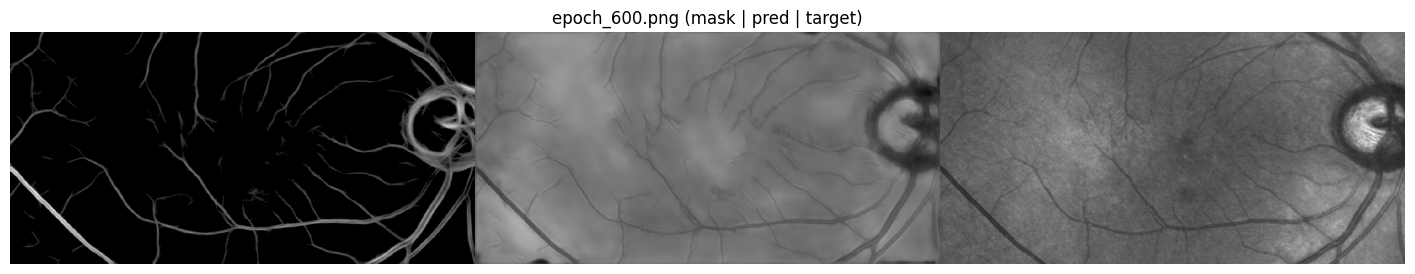

In [8]:
import matplotlib.pyplot as plt

preview_files = sorted((OUTPUT_DIR / 'previews').glob('epoch_*.png'))
print('Preview count:', len(preview_files))
if preview_files:
    sample = preview_files[-1]
    with Image.open(sample) as img:
        plt.figure(figsize=(18, 6))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(sample.name + ' (mask | pred | target)')
        plt.show()
        
